# Code with explicit math imlpementation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os
from tensor_decompositions import compute_error, compute_error_normalized_by_species

In [2]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}
Lx, Ly = 12.5, 15.6
print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
print(tensor_.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]

# Create log-transformed tensor
epsilon = 1e-10
tensor_combustion_log = np.zeros_like(tensor_combustion)
for i in range(tensor_combustion.shape[2]):
    tensor_combustion_log[:, :, i, :] = np.log(np.maximum(tensor_combustion[:, :, i, :], epsilon))
print(f"Log tensor created with shape: {tensor_combustion_log.shape}")

Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


(400, 320, 8, 200)
Data loading complete!
Log tensor created with shape: (400, 320, 8, 200)


In [3]:
def select_rank_by_ratio(array, varepsilon):
    sorted_array = np.sort(array)[::-1]
    total_energy = np.sum(sorted_array)
    cumulative_energy = np.cumsum(sorted_array)
    num_components = np.sum(cumulative_energy <= varepsilon * total_energy) + 1
    return min(num_components, len(array))

In [4]:
# Sequentially truncated HOSVD on log tensor
start_t = time.time()
factors_st = []
current_tensor = tensor_combustion_log.copy()

for mode in range(current_tensor.ndim):
    unfolded = tl.unfold(current_tensor, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor = tl.tenalg.mode_dot(current_tensor, U_trunc.T, mode)
    factors_st.append(U_trunc)
core_st = current_tensor
end_t = time.time()
st_time = end_t - start_t
print(f"stHOSVD computed in {st_time:.2f} seconds")
print(core_st.shape)

# Reconstruct in log space
reconstruction_st_log = tl.tenalg.multi_mode_dot(core_st, factors_st, [0,1,2,3])

# Transform back to original space
reconstruction_st = np.exp(reconstruction_st_log) - epsilon

print(np.allclose(reconstruction_st, tensor_combustion))
error_st = compute_error(tensor_combustion, reconstruction_st)
print(f"stHOSVD relative error: {error_st:.6f}")

84
65
7
161
stHOSVD computed in 1.57 seconds
(84, 65, 7, 161)
False
stHOSVD relative error: 0.043538


In [5]:
# Subsampled HOSVD (Gram matrix) on log tensor
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    print(unfolded.shape)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

(400, 64000)
74
(320, 80000)
65
(8, 3200000)
7
(200, 128000)
160
sub HOSVD computed in 0.99 seconds
Subsampled HOSVD computed in 0.99 seconds
False
Subsampled HOSVD relative error: 0.051311


In [6]:
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
    trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = U[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

74
65
7
160
sub HOSVD computed in 9.34 seconds
Subsampled HOSVD computed in 9.34 seconds
False
Subsampled HOSVD relative error: 0.051311


# Generated Code

In [7]:
# Comparison of subsampled HOSVD with different subsampling rates
subsampling_rates = [1, 2, 3, 5, 10]
results_gram = {'rates': [], 'times': [], 'errors': []}
results_svd = {'rates': [], 'times': [], 'errors': []}

for rate in subsampling_rates:
    print(f"\n{'='*60}")
    print(f"Processing subsampling rate: {rate}")
    print(f"{'='*60}")
    
    # ============ Gram Matrix Formulation ============
    print(f"\n--- Gram Matrix Formulation (rate={rate}) ---")
    start_t = time.time()
    factors_gram = []
    
    for mode in range(tensor_combustion_log.ndim):
        # Create subsampling slicing
        unfolded = tl.unfold(
            tensor_combustion_log[tuple(
                slice(None) if d == mode else slice(None, None, rate) 
                for d in range(tensor_combustion_log.ndim)
            )], 
            mode
        )
        
        # Compute Gram matrix
        g_matrix = unfolded @ unfolded.T
        eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
        eigenvalues = np.sqrt(np.abs(eigenvalues))
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Truncate
        trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
        U_trunc = eigenvectors[:, :trunc_idx].real
        factors_gram.append(U_trunc)
    
    # Compute core
    core_gram = tl.tenalg.multi_mode_dot(
        tensor_combustion_log, 
        [f.T for f in factors_gram], 
        modes=list(range(tensor_combustion_log.ndim))
    )
    
    end_t = time.time()
    gram_time = end_t - start_t
    
    # Reconstruct
    reconstruction_gram_log = tl.tenalg.multi_mode_dot(core_gram, factors_gram, [0,1,2,3])
    reconstruction_gram = np.exp(reconstruction_gram_log) - epsilon
    error_gram = compute_error(tensor_combustion, reconstruction_gram)
    
    results_gram['rates'].append(rate)
    results_gram['times'].append(gram_time)
    results_gram['errors'].append(error_gram)
    
    print(f"Time: {gram_time:.3f} seconds")
    print(f"Reconstruction error: {error_gram:.6f}")
    
    # ============ SVD Formulation ============
    print(f"\n--- SVD Formulation (rate={rate}) ---")
    start_t = time.time()
    factors_svd = []
    
    for mode in range(tensor_combustion_log.ndim):
        # Create subsampling slicing
        unfolded = tl.unfold(
            tensor_combustion_log[tuple(
                slice(None) if d == mode else slice(None, None, rate) 
                for d in range(tensor_combustion_log.ndim)
            )], 
            mode
        )
        
        # Compute SVD
        U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
        
        # Truncate
        trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
        U_trunc = U[:, :trunc_idx].real
        factors_svd.append(U_trunc)
    
    # Compute core
    core_svd = tl.tenalg.multi_mode_dot(
        tensor_combustion_log, 
        [f.T for f in factors_svd], 
        modes=list(range(tensor_combustion_log.ndim))
    )
    
    end_t = time.time()
    svd_time = end_t - start_t
    
    # Reconstruct
    reconstruction_svd_log = tl.tenalg.multi_mode_dot(core_svd, factors_svd, [0,1,2,3])
    reconstruction_svd = np.exp(reconstruction_svd_log) - epsilon
    error_svd = compute_error(tensor_combustion, reconstruction_svd)
    
    results_svd['rates'].append(rate)
    results_svd['times'].append(svd_time)
    results_svd['errors'].append(error_svd)
    
    print(f"Time: {svd_time:.3f} seconds")
    print(f"Reconstruction error: {error_svd:.6f}")

print(f"\n{'='*60}")
print("All computations completed!")
print(f"{'='*60}")


Processing subsampling rate: 1

--- Gram Matrix Formulation (rate=1) ---
Time: 2.673 seconds
Reconstruction error: 0.041639

--- SVD Formulation (rate=1) ---
Time: 103.826 seconds
Reconstruction error: 0.041639

Processing subsampling rate: 2

--- Gram Matrix Formulation (rate=2) ---
Time: 2.859 seconds
Reconstruction error: 0.051311

--- SVD Formulation (rate=2) ---
Time: 9.727 seconds
Reconstruction error: 0.051311

Processing subsampling rate: 3

--- Gram Matrix Formulation (rate=3) ---
Time: 0.528 seconds
Reconstruction error: 0.060234

--- SVD Formulation (rate=3) ---
Time: 2.327 seconds
Reconstruction error: 0.060234

Processing subsampling rate: 5

--- Gram Matrix Formulation (rate=5) ---
Time: 0.469 seconds
Reconstruction error: 0.079465

--- SVD Formulation (rate=5) ---
Time: 0.895 seconds
Reconstruction error: 0.079465

Processing subsampling rate: 10

--- Gram Matrix Formulation (rate=10) ---
Time: 0.232 seconds
Reconstruction error: 0.168477

--- SVD Formulation (rate=10) 

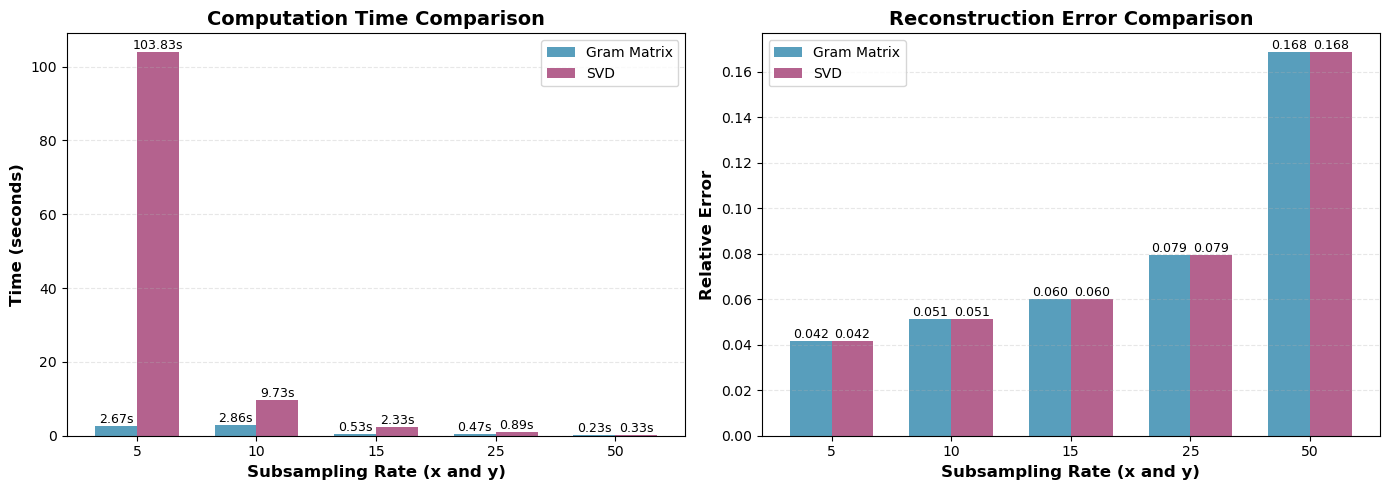


SUMMARY TABLE
Rate       Gram Time (s)   SVD Time (s)    Gram Error      SVD Error      
--------------------------------------------------------------------------------
1          2.673           103.826         0.041639        0.041639       
2          2.859           9.727           0.051311        0.051311       
3          0.528           2.327           0.060234        0.060234       
5          0.469           0.895           0.079465        0.079465       
10         0.232           0.325           0.168477        0.168477       


In [8]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Computation Times
ax1 = axes[0]
x = np.arange(len(subsampling_rates))
width = 0.35

bars1 = ax1.bar(x - width/2, results_gram['times'], width, 
                label='Gram Matrix', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x + width/2, results_svd['times'], width, 
                label='SVD', color='#A23B72', alpha=0.8)

ax1.set_xlabel('Subsampling Rate (x and y)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([rate * 5 for rate in subsampling_rates])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Reconstruction Errors
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, results_gram['errors'], width, 
                label='Gram Matrix', color='#2E86AB', alpha=0.8)
bars4 = ax2.bar(x + width/2, results_svd['errors'], width, 
                label='SVD', color='#A23B72', alpha=0.8)

ax2.set_xlabel('Subsampling Rate (x and y)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Relative Error', fontsize=12, fontweight='bold')
ax2.set_title('Reconstruction Error Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([rate * 5 for rate in subsampling_rates])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Rate':<10} {'Gram Time (s)':<15} {'SVD Time (s)':<15} {'Gram Error':<15} {'SVD Error':<15}")
print("-"*80)
for i in range(len(subsampling_rates)):
    print(f"{results_gram['rates'][i]:<10} {results_gram['times'][i]:<15.3f} "
          f"{results_svd['times'][i]:<15.3f} {results_gram['errors'][i]:<15.6f} "
          f"{results_svd['errors'][i]:<15.6f}")
print("="*80)

# Random Subsampling on First 2 Dimensions

In [9]:
# Random subsampling on first 2 dimensions (Ny, Nx)
# Keep the other dimensions (species and time) intact
np.random.seed(42)  # For reproducibility

# Get dimensions
Ny, Nx, n_species, n_snapshots = tensor_combustion_log.shape

# Define subsampling factor (e.g., sample 1/4 of the points along each dimension)
subsample_factor = 2  # Sample every 2nd point on average

# Calculate number of points to sample along each dimension
Ny_sampled = Ny // subsample_factor
Nx_sampled = Nx // subsample_factor

# Randomly select indices for each dimension independently
sampled_y_indices = np.sort(np.random.choice(Ny, size=Ny_sampled, replace=False))
sampled_x_indices = np.sort(np.random.choice(Nx, size=Nx_sampled, replace=False))

print(f"Original shape: {tensor_combustion_log.shape}")
print(f"Sampling {Ny_sampled} points from Y dimension (out of {Ny})")
print(f"Sampling {Nx_sampled} points from X dimension (out of {Nx})")
print(f"First 10 Y indices: {sampled_y_indices[:10]}")
print(f"First 10 X indices: {sampled_x_indices[:10]}")

# Create subsampled tensor using meshgrid indexing
# This maintains 4D structure: (Ny_sampled, Nx_sampled, n_species, n_snapshots)
tensor_random_sub = tensor_combustion_log[np.ix_(sampled_y_indices, sampled_x_indices,
                                                   np.arange(n_species), np.arange(n_snapshots))]
print(f"Randomly subsampled tensor shape: {tensor_random_sub.shape}")

# Store the sampled indices for later visualization
sampled_points = {
    'y_indices': sampled_y_indices,
    'x_indices': sampled_x_indices
}

Original shape: (400, 320, 8, 200)
Sampling 200 points from Y dimension (out of 400)
Sampling 160 points from X dimension (out of 320)
First 10 Y indices: [ 0  3  5  6  7  9 10 15 16 17]
First 10 X indices: [ 2  5  6  8 10 13 14 17 19 21]
Randomly subsampled tensor shape: (200, 160, 8, 200)


In [11]:
# Apply HOSVD on randomly subsampled tensor (Gram matrix formulation)
start_t = time.time()
factors_random = []

for mode in range(tensor_random_sub.ndim):
    unfolded = tl.unfold(tensor_random_sub, mode)
    print(f"Mode {mode} unfolded shape: {unfolded.shape}")
    
    # Compute Gram matrix
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Truncate
    trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
    print(f"Mode {mode} truncation rank: {trunc_idx}")
    U_trunc = eigenvectors[:, :trunc_idx].real
    factors_random.append(U_trunc)

# Compute core tensor using full tensor with random factors
# This is similar to subsampled HOSVD where we compute factors on subsampled data
# but apply them to the full tensor
core_random = tl.tenalg.multi_mode_dot(
    tensor_combustion_log, 
    [f.T for f in factors_random], 
    modes=list(range(tensor_combustion_log.ndim))
)

end_t = time.time()
random_time = end_t - start_t

print(f"\nRandom subsampled HOSVD computed in {random_time:.3f} seconds")
print(f"Core tensor shape: {core_random.shape}")

# Reconstruct the full tensor
reconstruction_random_log = tl.tenalg.multi_mode_dot(
    core_random, 
    factors_random, 
    list(range(len(factors_random)))
)

# Transform back to original space
reconstruction_random = np.exp(reconstruction_random_log) - epsilon

# Compute error on full tensor
error_random = compute_error(tensor_combustion, reconstruction_random)
print(f"Random subsampled HOSVD relative error: {error_random:.6f}")

Mode 0 unfolded shape: (200, 256000)
Mode 0 truncation rank: 65
Mode 1 unfolded shape: (160, 320000)
Mode 1 truncation rank: 47
Mode 2 unfolded shape: (8, 6400000)
Mode 2 truncation rank: 7
Mode 3 unfolded shape: (200, 256000)
Mode 3 truncation rank: 165


ValueError: shapes (400, 320, 8, 200) and (65, 200) not aligned in mode-0 multiplication: 400 (mode 0) != 200 (dim 1 of matrix)

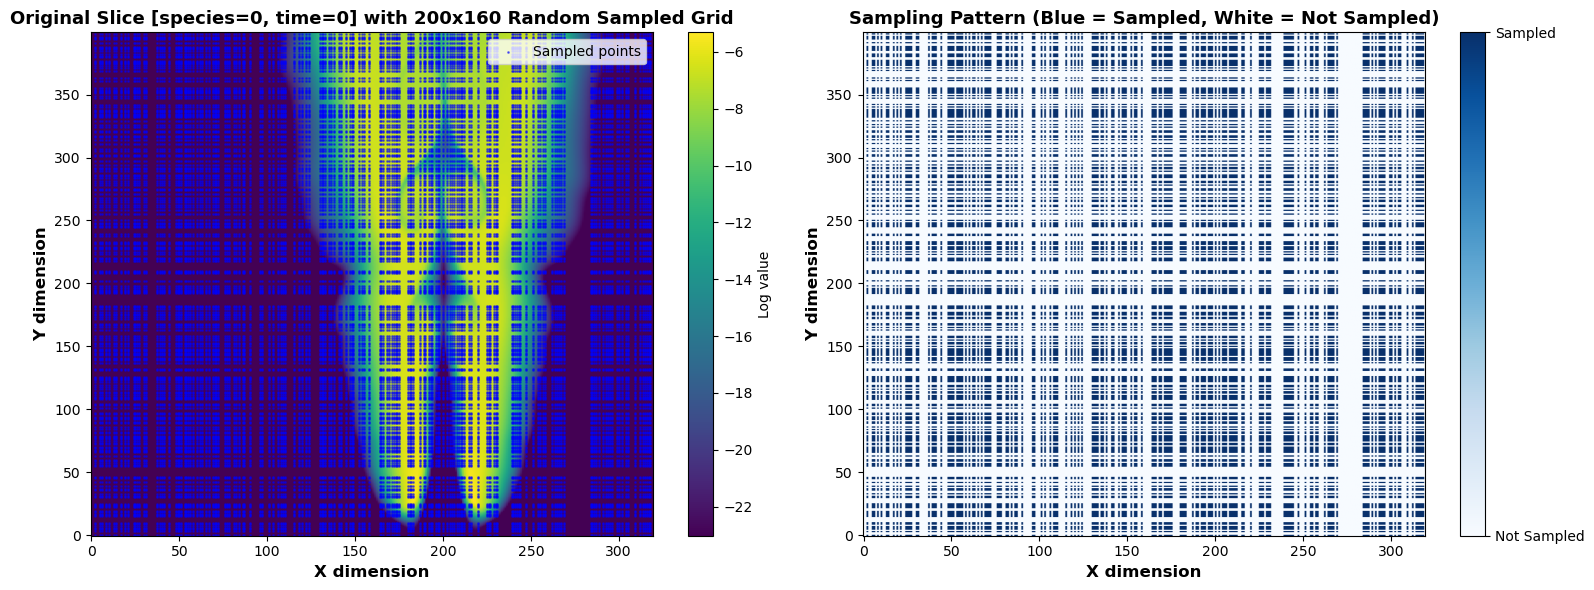


Visualization complete!
Sampled grid: 200 x 160 = 32000 points
Original grid: 400 x 320 = 128000 points
Sampling ratio: 25.0%


In [ ]:
# Visualize sampled points on the 2D slice
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the 2D slice
slice_2d = tensor_combustion_log[:, :, 0, 0]

# Create meshgrid of sampled positions
yy_sampled, xx_sampled = np.meshgrid(sampled_y_indices, sampled_x_indices, indexing='ij')

# Plot 1: Original slice with sampled points overlaid in blue
ax1 = axes[0]
im1 = ax1.imshow(slice_2d, cmap='viridis', aspect='auto', origin='lower')
# Overlay sampled points in blue
ax1.scatter(xx_sampled.ravel(), yy_sampled.ravel(), c='blue', s=1, alpha=0.5, label='Sampled points')
ax1.set_xlabel('X dimension', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y dimension', fontsize=12, fontweight='bold')
ax1.set_title(f'Original Slice [species=0, time=0] with {len(sampled_y_indices)}x{len(sampled_x_indices)} Random Sampled Grid', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
plt.colorbar(im1, ax=ax1, label='Log value')

# Plot 2: Mask showing only sampled vs non-sampled points
ax2 = axes[1]
# Create a binary mask: 0 for non-sampled, 1 for sampled
mask = np.zeros((Ny, Nx))
mask[np.ix_(sampled_y_indices, sampled_x_indices)] = 1
im2 = ax2.imshow(mask, cmap='Blues', aspect='auto', origin='lower', vmin=0, vmax=1)
ax2.set_xlabel('X dimension', fontsize=12, fontweight='bold')
ax2.set_ylabel('Y dimension', fontsize=12, fontweight='bold')
ax2.set_title(f'Sampling Pattern (Blue = Sampled, White = Not Sampled)', 
              fontsize=13, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0, 1])
cbar2.set_ticklabels(['Not Sampled', 'Sampled'])

plt.tight_layout()
plt.show()

n_points_total = Ny * Nx
n_points_sampled = len(sampled_y_indices) * len(sampled_x_indices)
print(f"\nVisualization complete!")
print(f"Sampled grid: {len(sampled_y_indices)} x {len(sampled_x_indices)} = {n_points_sampled} points")
print(f"Original grid: {Ny} x {Nx} = {n_points_total} points")
print(f"Sampling ratio: {100*n_points_sampled/n_points_total:.1f}%")

# Comparison: stHOSVD on Original vs Log Tensor

In [25]:
# Run stHOSVD on original tensor (tensor_combustion)
print("Running stHOSVD on original tensor...")
start_t = time.time()
factors_st_orig = []
current_tensor_orig = tensor_combustion.copy()
truncation_indices = []
for mode in range(current_tensor_orig.ndim):
    unfolded = tl.unfold(current_tensor_orig, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.999)
    truncation_indices.append(trunc_idx)
    print(f"Mode {mode}: rank = {trunc_idx}")
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor_orig = tl.tenalg.mode_dot(current_tensor_orig, U_trunc.T, mode)
    factors_st_orig.append(U_trunc)

core_st_orig = current_tensor_orig
end_t = time.time()
st_time_orig = end_t - start_t

# Reconstruct
reconstruction_st_orig = tl.tenalg.multi_mode_dot(core_st_orig, factors_st_orig, [0,1,2,3])
error_st_orig = compute_error(tensor_combustion, reconstruction_st_orig)

print(f"stHOSVD on original tensor computed in {st_time_orig:.2f} seconds")
print(f"Core shape: {core_st_orig.shape}")
print(f"Relative error: {error_st_orig:.6f}")
print()

# Run stHOSVD on log tensor (tensor_combustion_log) - rerun for comparison
print("Running stHOSVD on log tensor...")
start_t = time.time()
factors_st_log = []
current_tensor_log = tensor_combustion_log.copy()

for mode in range(current_tensor_log.ndim):
    unfolded = tl.unfold(current_tensor_log, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = truncation_indices[mode]
    print(f"Mode {mode}: rank = {trunc_idx}")
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor_log = tl.tenalg.mode_dot(current_tensor_log, U_trunc.T, mode)
    factors_st_log.append(U_trunc)

core_st_log = current_tensor_log
end_t = time.time()
st_time_log = end_t - start_t

# Reconstruct in log space and transform back
reconstruction_st_log_space = tl.tenalg.multi_mode_dot(core_st_log, factors_st_log, [0,1,2,3])
reconstruction_st_log = np.exp(reconstruction_st_log_space) 
error_st_log = compute_error(tensor_combustion, reconstruction_st_log)

print(f"stHOSVD on log tensor computed in {st_time_log:.2f} seconds")
print(f"Core shape: {core_st_log.shape}")
print(f"Relative error: {error_st_log:.6f}")

Running stHOSVD on original tensor...
Mode 0: rank = 167
Mode 1: rank = 79
Mode 2: rank = 6
Mode 3: rank = 199
stHOSVD on original tensor computed in 2.45 seconds
Core shape: (167, 79, 6, 199)
Relative error: 0.002161

Running stHOSVD on log tensor...
Mode 0: rank = 167
Mode 1: rank = 79
Mode 2: rank = 6
Mode 3: rank = 199
stHOSVD on log tensor computed in 2.06 seconds
Core shape: (167, 79, 6, 199)
Relative error: 0.253854


In [ ]:
# Compute normalized errors by species
print("\n" + "="*80)
print("NORMALIZED ERROR BY SPECIES (RMSE / Mean per species)")
print("="*80)

# Compute for original tensor reconstruction
overall_error_orig, per_species_errors_orig = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_orig, species_axis=2
)

# Compute for log tensor reconstruction
overall_error_log, per_species_errors_log = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_log, species_axis=2
)

print(f"\n{'Species':<10} {'Original Tensor':<20} {'Log Tensor':<20} {'Improvement':<15}")
print("-"*80)
for species_idx in range(n_species):
    improvement = (per_species_errors_orig[species_idx] - per_species_errors_log[species_idx]) / per_species_errors_orig[species_idx] * 100
    print(f"{species_names[species_idx]:<10} {per_species_errors_orig[species_idx]:<20.6f} "
          f"{per_species_errors_log[species_idx]:<20.6f} {improvement:>+13.2f}%")

print("-"*80)
print(f"{'OVERALL':<10} {overall_error_orig:<20.6f} {overall_error_log:<20.6f} "
      f"{(overall_error_orig - overall_error_log)/overall_error_orig * 100:>+13.2f}%")
print("="*80)

# Create bar plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(n_species)
width = 0.35

bars1 = ax.bar(x - width/2, per_species_errors_orig, width, 
               label='Original Tensor', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, per_species_errors_log, width, 
               label='Log Tensor', color='#A23B72', alpha=0.8)

ax.set_xlabel('Species', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Error (RMSE / Mean)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Error by Species: Original vs Log Tensor stHOSVD', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

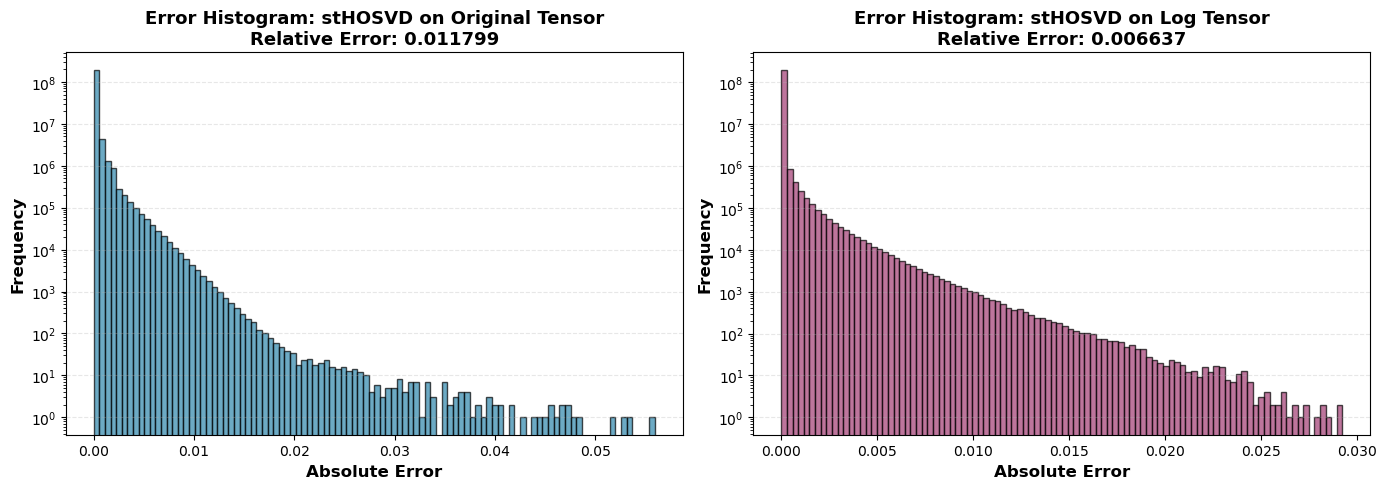


Original tensor - Max error: 5.590654e-02, Mean error: 8.939822e-05
Log tensor - Max error: 2.921892e-02, Mean error: 1.710811e-05


In [21]:
# Plot error histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute element-wise errors
error_orig = np.abs(tensor_combustion - reconstruction_st_orig)
error_log = np.abs(tensor_combustion - reconstruction_st_log)

# Plot 1: Error histogram for original tensor
ax1 = axes[0]
ax1.hist(error_orig.ravel(), bins=100, color='#2E86AB', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title(f'Error Histogram: stHOSVD on Original Tensor\nRelative Error: {error_st_orig:.6f}', 
              fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_yscale('log')

# Plot 2: Error histogram for log tensor
ax2 = axes[1]
ax2.hist(error_log.ravel(), bins=100, color='#A23B72', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title(f'Error Histogram: stHOSVD on Log Tensor\nRelative Error: {error_st_log:.6f}', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nOriginal tensor - Max error: {np.max(error_orig):.6e}, Mean error: {np.mean(error_orig):.6e}")
print(f"Log tensor - Max error: {np.max(error_log):.6e}, Mean error: {np.mean(error_log):.6e}")

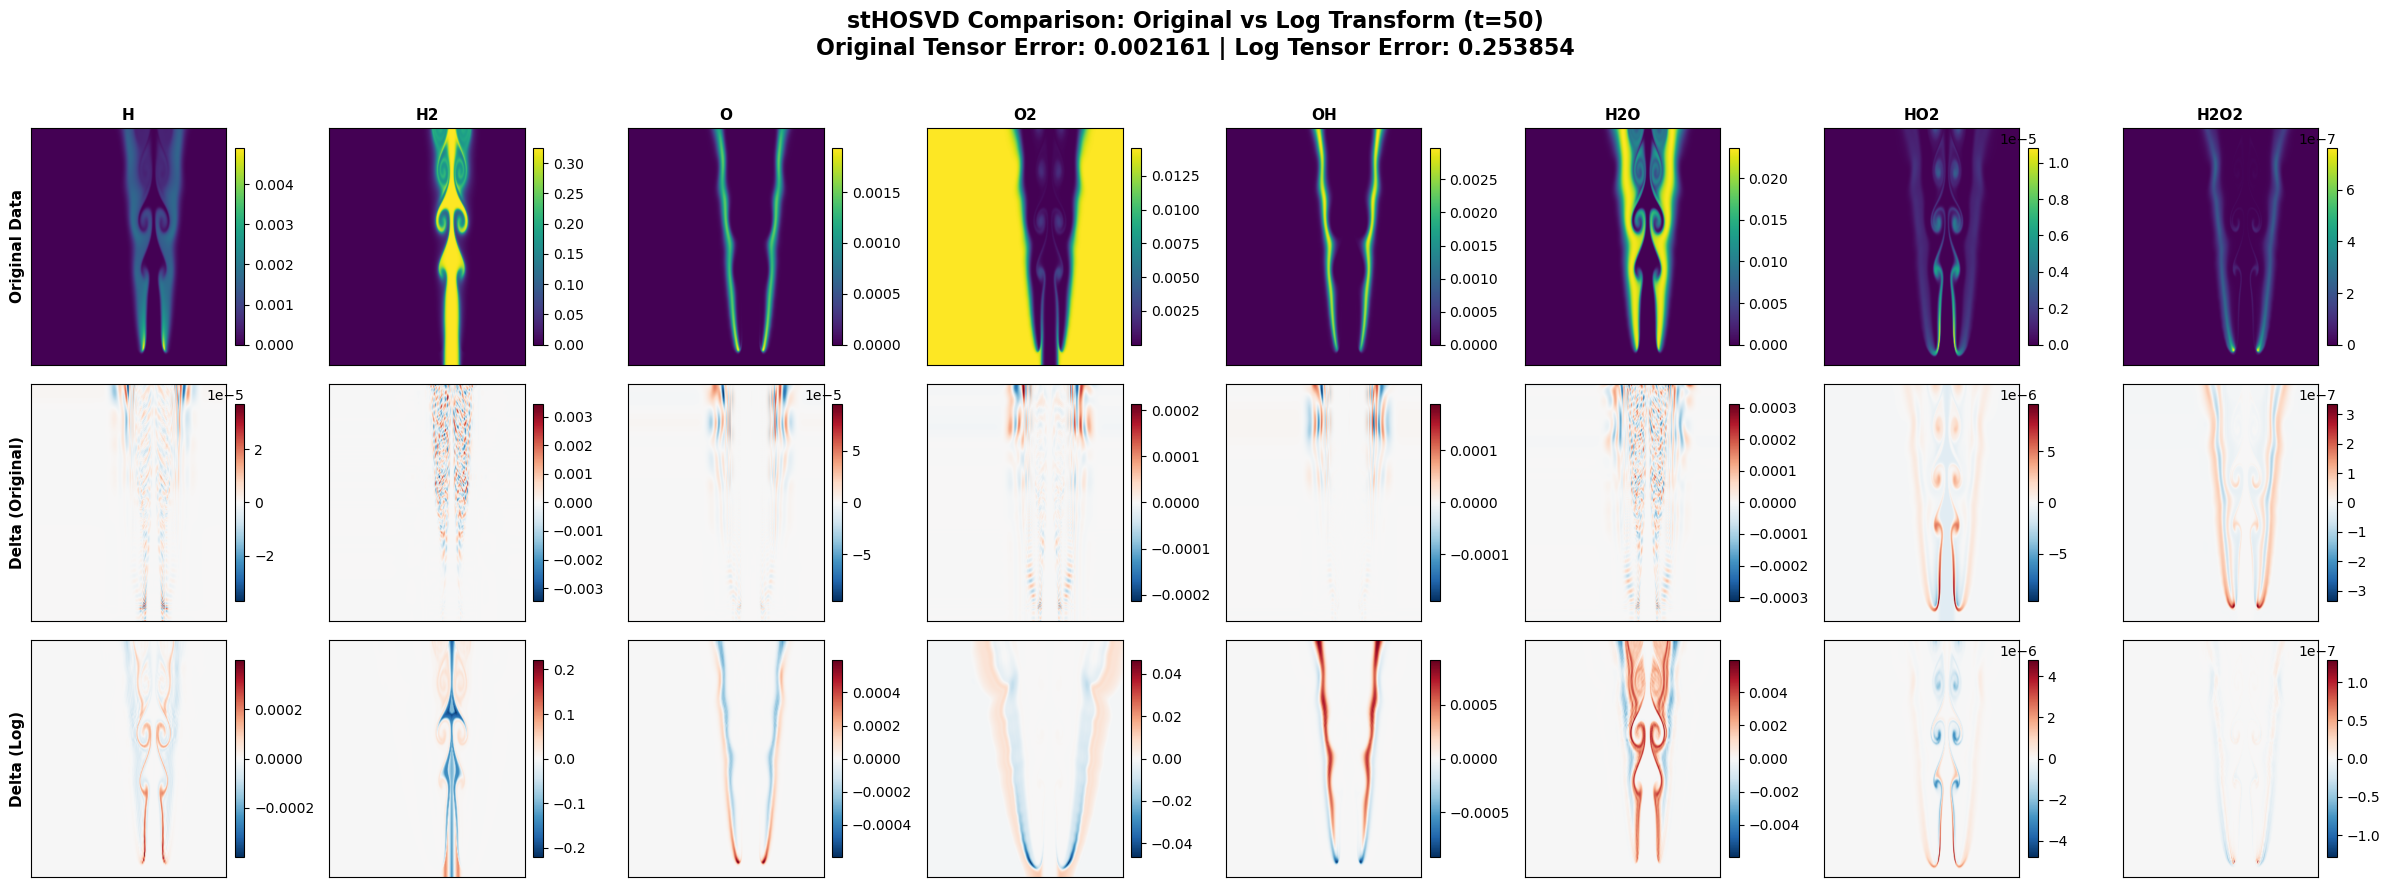


Error Statistics by Species:
Species    Original RMSE        Log RMSE            
--------------------------------------------------------------------------------
H          2.400643e-06         2.505101e-05        
H2         1.925246e-04         2.268453e-02        
O          6.464795e-06         4.425183e-05        
O2         1.692238e-05         3.662804e-03        
OH         1.270439e-05         1.182663e-04        
H2O        2.777724e-05         8.623204e-04        
HO2        6.822136e-07         2.838036e-07        
H2O2       2.393152e-08         2.951533e-09        


In [26]:
# Create 3x8 subplot visualization for all species at time step 0
time_idx = 50
n_species = 8

fig, axes = plt.subplots(3, n_species, figsize=(24, 9))

# Add main title with error information
fig.suptitle(f'stHOSVD Comparison: Original vs Log Transform (t={time_idx})\n' +
             f'Original Tensor Error: {error_st_orig:.6f} | Log Tensor Error: {error_st_log:.6f}',
             fontsize=16, fontweight='bold', y=0.98)

for species_idx in range(n_species):
    # Get data for this species at time step 0
    original = tensor_combustion[:, :, species_idx, time_idx]
    reconstructed_orig = reconstruction_st_orig[:, :, species_idx, time_idx]
    reconstructed_log = reconstruction_st_log[:, :, species_idx, time_idx]
    
    # Compute deltas
    delta_orig = original - reconstructed_orig
    delta_log = original - reconstructed_log
    
    # Row 1: Original data
    ax1 = axes[0, species_idx]
    im1 = ax1.imshow(original, cmap='viridis', aspect='auto', origin='lower')
    ax1.set_title(f'{species_names[species_idx]}', fontsize=11, fontweight='bold')
    if species_idx == 0:
        ax1.set_ylabel('Original Data', fontsize=11, fontweight='bold')
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Row 2: Delta (original - reconstructed from original tensor)
    ax2 = axes[1, species_idx]
    vmax_orig = np.max(np.abs(delta_orig))
    im2 = ax2.imshow(delta_orig, cmap='RdBu_r', aspect='auto', origin='lower', 
                     vmin=-vmax_orig, vmax=vmax_orig)
    if species_idx == 0:
        ax2.set_ylabel('Delta (Original)', fontsize=11, fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Row 3: Delta (original - reconstructed from log tensor)
    ax3 = axes[2, species_idx]
    vmax_log = np.max(np.abs(delta_log))
    im3 = ax3.imshow(delta_log, cmap='RdBu_r', aspect='auto', origin='lower',
                     vmin=-vmax_log, vmax=vmax_log)
    if species_idx == 0:
        ax3.set_ylabel('Delta (Log)', fontsize=11, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print statistics for each species
print("\nError Statistics by Species:")
print("="*80)
print(f"{'Species':<10} {'Original RMSE':<20} {'Log RMSE':<20}")
print("-"*80)
for species_idx in range(n_species):
    orig_slice = tensor_combustion[:, :, species_idx, :]
    recon_orig_slice = reconstruction_st_orig[:, :, species_idx, :]
    recon_log_slice = reconstruction_st_log[:, :, species_idx, :]
    
    rmse_orig = np.sqrt(np.mean((orig_slice - recon_orig_slice)**2))
    rmse_log = np.sqrt(np.mean((orig_slice - recon_log_slice)**2))
    
    print(f"{species_names[species_idx]:<10} {rmse_orig:<20.6e} {rmse_log:<20.6e}")
print("="*80)

In [ ]:
# Create animated GIF showing all time steps
from matplotlib.animation import FuncAnimation, PillowWriter

print("Creating animated GIF...")
print(f"Total frames: {n_snapshots}")

# Create figure and axes
fig, axes = plt.subplots(3, n_species, figsize=(24, 9))

# Initialize image objects for each subplot
images = []
for species_idx in range(n_species):
    row_images = []
    for row_idx in range(3):
        ax = axes[row_idx, species_idx]
        if row_idx == 0:
            im = ax.imshow(np.zeros((tensor_combustion.shape[0], tensor_combustion.shape[1])), 
                          cmap='viridis', aspect='auto', origin='lower')
        else:
            im = ax.imshow(np.zeros((tensor_combustion.shape[0], tensor_combustion.shape[1])), 
                          cmap='RdBu_r', aspect='auto', origin='lower')
        row_images.append(im)
        
        # Set labels and titles
        if row_idx == 0:
            ax.set_title(f'{species_names[species_idx]}', fontsize=11, fontweight='bold')
        if species_idx == 0:
            if row_idx == 0:
                ax.set_ylabel('Original Data', fontsize=11, fontweight='bold')
            elif row_idx == 1:
                ax.set_ylabel('Delta (Original)', fontsize=11, fontweight='bold')
            else:
                ax.set_ylabel('Delta (Log)', fontsize=11, fontweight='bold')
        
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    images.append(row_images)

# Main title
title = fig.suptitle('', fontsize=16, fontweight='bold', y=0.98)

# Animation update function
def update(frame):
    time_idx = frame
    
    # Update title
    title.set_text(f'stHOSVD Comparison: Original vs Log Transform (t={time_idx}/{n_snapshots-1})\n' +
                   f'Original Tensor Error: {error_st_orig:.6f} | Log Tensor Error: {error_st_log:.6f}')
    
    for species_idx in range(n_species):
        # Get data for this species at current time step
        original = tensor_combustion[:, :, species_idx, time_idx]
        reconstructed_orig = reconstruction_st_orig[:, :, species_idx, time_idx]
        reconstructed_log = reconstruction_st_log[:, :, species_idx, time_idx]
        
        # Compute deltas
        delta_orig = original - reconstructed_orig
        delta_log = original - reconstructed_log
        
        # Update row 1: Original data
        images[species_idx][0].set_array(original)
        images[species_idx][0].set_clim(vmin=original.min(), vmax=original.max())
        
        # Update row 2: Delta (original)
        vmax_orig = np.max(np.abs(delta_orig))
        images[species_idx][1].set_array(delta_orig)
        images[species_idx][1].set_clim(vmin=-vmax_orig, vmax=vmax_orig)
        
        # Update row 3: Delta (log)
        vmax_log = np.max(np.abs(delta_log))
        images[species_idx][2].set_array(delta_log)
        images[species_idx][2].set_clim(vmin=-vmax_log, vmax=vmax_log)
    
    return [img for row in images for img in row] + [title]

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Create animation
anim = FuncAnimation(fig, update, frames=n_snapshots, interval=100, blit=False)

# Save as GIF
output_filename = 'stHOSVD_comparison_animation.gif'
print(f"Saving animation to {output_filename}...")
writer = PillowWriter(fps=10)
anim.save(output_filename, writer=writer)
print(f"Animation saved successfully!")

plt.close()

# Display a preview of a few frames
print(f"\nAnimation created with {n_snapshots} frames at 10 FPS")
print(f"Duration: {n_snapshots/10:.1f} seconds")
print(f"File saved as: {output_filename}")